## 0. Packages and Dataloading

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from IPython.display import Image, display, display, clear_output
import ipywidgets as widgets
from pathlib import Path
from glob import glob
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import sklearn
import h5py
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.curation as sc
import spikeinterface.widgets as sw



import bombcell as bc

import warnings
warnings.filterwarnings("ignore")


sys.path.append("/home/ehefti/Github/DPQC")
# sys.path.append("C:/Users/elias/OneDrive - ETH Zurich/2025FS - Master Thesis/1 - Scripts/Github/DPQC")
import MaxTwo_Spikesorting.scripts.spike_sorting as ss
import MaxTwo_Activity_Screening.screen_maxtwo_activity as sma
import KiloSort_Quality_Control.unit_labeling as ul

## 1. Recording Overview

Found 24 wells in /net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5
Analyzing 10 seconds from each well for a rough overview.


Processing Wells:   0%|          | 0/24 [00:00<?, ?it/s]

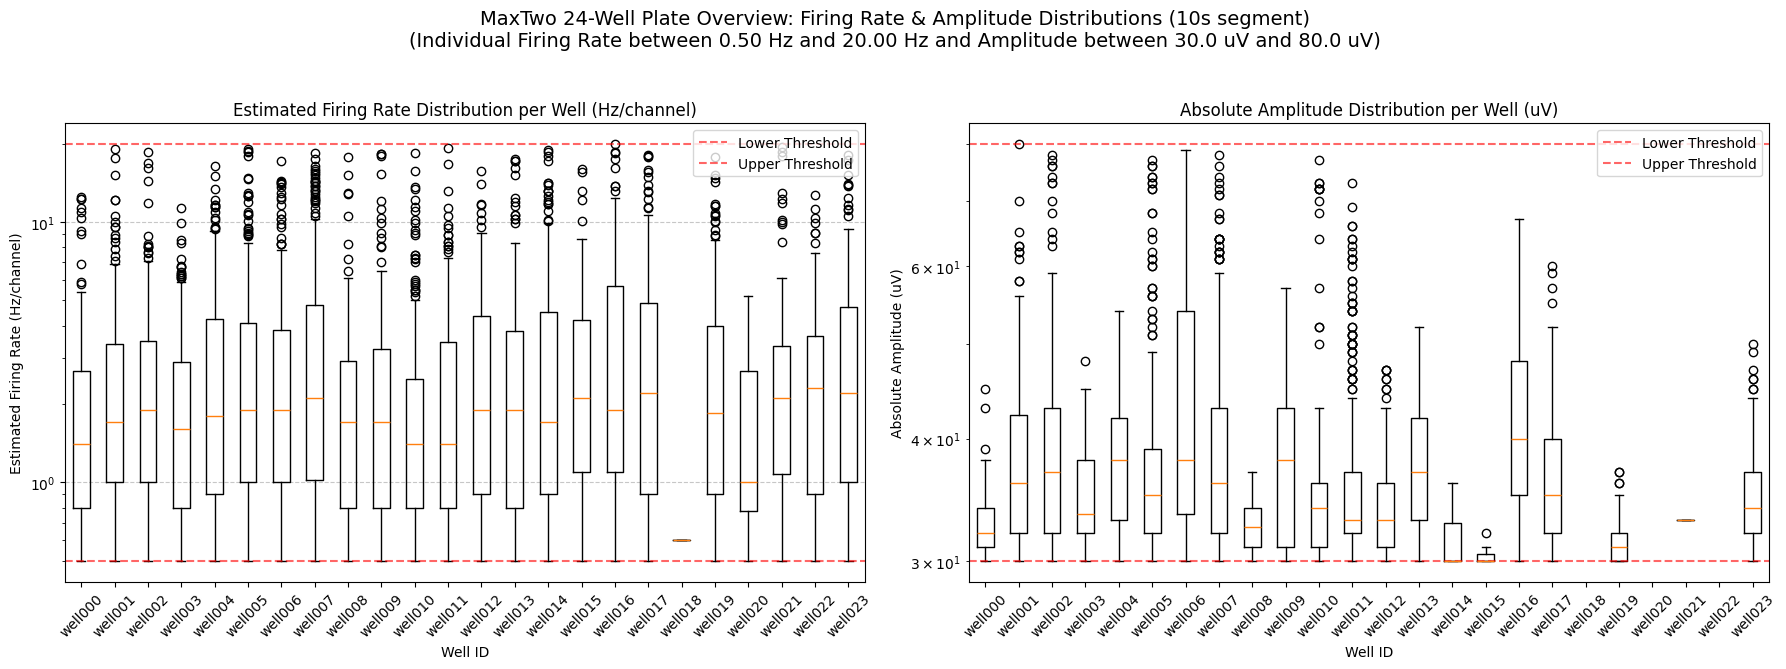

In [3]:
rec_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
#rec_path = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/data.raw.h5"
df_summary, rate_dist, amp_dist = sma.screen_maxtwo_activity(rec_path, segment_duration_s=10,
                                                             rate_lower_threshold = 0.5,
                                                             rate_upper_threshold = 20,
                                                             amp_lower_threshold = 30,
                                                             amp_upper_threshold = 80)



#log scale

## 2. Spikesorting
_This part of the pipeline is computationally heavy. It is advisable to run this on a GPU or Cluster._

In [4]:
# Choose sorter and set parameters
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/ehefti/Github/Kilosort')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)

sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5 #6 als Standardwert
sorter_params['minFR'] = 0.01 #Lower value -> less units that get automatically deleted
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
sorter_params['NT'] = 64*1024 + 64 #Batch size -> Wieviel wird auf einmal angeschaut


# Set your paths
# Linux: '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/.../data.raw.h5' 
# Windows: 'S:/group/hierlemann02/recordings/Maxtwo/.../data.raw.h5'

rec_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
save_root = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/EI_iNeurons/241218/T002523/Network/'
"""
rec_path = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/data.raw.h5"
save_root = "D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/"
"""
h5 = h5py.File(rec_path)
stream_ids = list(h5['wells'].keys())
stream_ids = stream_ids[0:24]

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/ehefti/Github/Kilosort


In [ ]:
for stream_id in tqdm(stream_ids):
    h5 = h5py.File(rec_path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(rec_path, stream_id=stream_id, rec_name=rec_name)
    ss.clean_sorting(rec, save_root, stream_id=stream_id, sorter=sorter, sorter_params=sorter_params, clear_files=True)

## 3. Qualitycontrol (Bombcell & SI-Model)

### 3.1 Bombcell

In [5]:
# Replace with your kilosort directory
well_id = 'well010'
ks_dir = 'D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/' #Path(save_root) / well_id / 'sorter_output'

# Set bombcell's output directory
save_path = Path(ks_dir) / "bc_output_test"
if not save_path.exists():
    save_path.mkdir(parents=True, exist_ok=True)

print(f"Using kilosort directory: {ks_dir}")

param = bc.get_default_parameters(ks_dir, kilosort_version=2)

# Modify some parameters
param['ephys_sample_rate'] = 10000  # Sample rate in Hz

h5 = h5py.File(rec_path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec = si.MaxwellRecordingExtractor(rec_path, stream_id=well_id, rec_name=rec_name)

param['nChannels'] = rec.get_num_channels()
param['raw_data_file'] = Path(ks_dir) / "recording.dat"
param['ephysKilosortPath']

pprint(param)

(quality_metrics, param, unit_type, unit_type_string) = bc.run_bombcell(ks_dir, save_path, param)

Using kilosort directory: D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 1e-05,
 'ephysKilosortPath': 'D:/Master '
                      'Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/',
 'ephys_meta_file': None,
 'ephys_sample_rate': 10000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin': 20,
 'keep_only_somatic': True,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'min

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Master Thesis/Data/EI_iNeurons/241218/T002523/Network/well000/sorter_output/spike_templates.npy'

See the metrics and the classification

In [ ]:
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

Take a look at your units in a GUI. Potentially adjust thresholds or change the classification:

In [ ]:
gui = bc.unit_quality_gui(
    ks_dir=ks_dir,
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=save_path,
)

#### Bombcell Philipp

In [ ]:
from mxw_bombcell.generate_sorting_path_list import generate_sorting_path_list
from mxw_bombcell.infer_sampling_rate import infer_sampling_rate
from mxw_bombcell.bombcell_to_phy import bombcell_to_phy


# Suppress all warnings
warnings.filterwarnings('ignore')

qc_root_path = 'D:/Master Thesis/Data/EI_iNeurons'
path_logic = ['24*', 'T002523', 'Network', 'well*', 'sorter_output']

sorting_path_list = generate_sorting_path_list(qc_root_path, path_logic)
print(f"Found {len(sorting_path_list)} sortings")

# PARAMS
rerun = 1  # 1 to re-run, 0 to skip if metrics are present
gain_to_uV = 6.2
verbose = 0

for i, sorting_path in enumerate(sorting_path_list):
    ephysKilosortPath = sorting_path
    sampling_rate = infer_sampling_rate(ephysKilosortPath)
    
    kilosortVersion = 2 # Change if using Kilosort4
    savePath = os.path.join(ephysKilosortPath, "bc_output")

    param = bc.get_default_parameters(kilosort_path=ephysKilosortPath, kilosort_version=kilosortVersion, gain_to_uV=gain_to_uV)

    param['extractRaw'] = 0
    param['ephys_sample_rate'] = sampling_rate

    param['nSyncChannels'] = 0
    param['removeDuplicateSpikes'] = 0
    param['minWvDuration'] = 200
    param['maxWvDuration'] = 1500
    param['tauR_valuesMin'] = 0.001
    param['tauR_valuesMax'] = 0.003
    param['maxRPVviolations'] = 0.05
    param['verbose'] = verbose
    param['computeDistanceMetrics'] = 1

    qMetricsExist = (len(glob(os.path.join(savePath, 'qMetric*.mat'))) > 0) or \
                    (os.path.exists(os.path.join(savePath, 'templates._bc_qMetrics.parquet')))

    if not qMetricsExist or rerun:
        spikeTimes_samples, spikeTemplates, templateWaveforms, templateAmplitudes, pcFeatures, \
        pcFeatureIdx, channelPositions = bc.load_ephys_data(ephysKilosortPath)
        
        if len(spikeTimes_samples) > 0 and param['ephys_sample_rate'] > 0:
            param['minNumSpikes'] = round(np.max(spikeTimes_samples) / param['ephys_sample_rate'] / 20)
        else:
            param['minNumSpikes'] = 0

        param['nChannels'] = channelPositions.shape[0] if channelPositions is not None else 0





        (
            qMetrics,
            param,
            unitType,
            unitTypeString,
        ) = bc.run_bombcell(
            ephysKilosortPath, savePath, param
        )


        """
        qMetric, runtimes = bc.get_all_quality_metrics(param=param, 
                                                       unique_templates=None,
                                                       spike_times_seconds=spikeTimes_samples, 
                                                       spike_clusters=spikeTemplates, 
                                                       template_waveforms=templateWaveforms, 
                                                       template_amplitudes=templateAmplitudes,
                                                       time_chunks=None,
                                                       pc_features=pcFeatures, 
                                                       pc_features_idx=pcFeatureIdx,
                                                       channel_positions=channelPositions, 
                                                       save_path=savePath)
        
        unitType, unitTypeString = bc.get_quality_unit_type(param, qMetric)
        """


bc_path_list = [os.path.join(sp, "bc_output") for sp in sorting_path_list]

overwrite = True
bombcell_to_phy(bc_path_list[:3], overwrite)

### 3.2 SI-Model

#### Train Model
You can train your own Model if you want - this is not necessary though. There is a model that works reasonably well for MaxTwo EPhys data. If you train your own model it might be more precise for your cell-line, but it takes a while to label your units manually and train the model to get reasonable results. The pretrained Model will be loaded in the next step of the pipeline, you can jump to "Apply Model".

##### Manual Labeling
Alternatively you can also download phy by following the instructions on the following GitHub repository: `https://github.com/cortex-lab/phy/`. Phy offers a GUI with more information about the units, but you will have to leave jupyter notebook and create a dedicated conda environment for it.

The documentation to explain the GUI can be found here `https://phy.readthedocs.io/en/latest/`

You can also start the GUI from python, but you will have to change the kernel which makes you loose your cached variables. Use the code below:



```python
from phy.apps.template import template_gui
from pathlib import Path

save_root = 'your/path/to/your/sorted/wells/'
well_id = 'well010'
params_path = Path(save_root) / well_id / 'sorter_output' / 'params.py'
template_gui(params_path)
```

##### Training your Model

In [ ]:
"""
# If you want to testrun the code you can use this function and skip the next code block:
rec_train, sorting_train, analyzer = generate_ground_truth_data(
    durations=[10], 
    sampling_frequency=30000, 
    num_channels=4
)
"""

In [6]:
# !! This controlls how many cores you're using, only increase if the server is not used by others !!
si.set_global_job_kwargs(n_jobs = 6) # For no parallelisation use n_jobs = -1
os.environ['HDF5_PLUGIN_PATH'] = '/home/ehefti/Github/DPQC/MaxTwo_Quality_Control/'

# Choose sorting to train the model on
well_id = 'well001'
path_to_sorting = Path(save_root) / well_id / 'sorter_output'
sorting_train = si.read_kilosort(folder_path=path_to_sorting)

# Real Recording Loading
h5 = h5py.File(rec_path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec_train = si.MaxwellRecordingExtractor(rec_path, stream_id=well_id, rec_name=rec_name)


analyzer = si.create_sorting_analyzer(sorting=sorting_train, recording=rec_train)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates'])
analyzer.compute(['spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])

estimate_sparsity (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

noise_level (workers: 6 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/435 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/435 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

noise_level (workers: 6 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/435 [00:00<?, ?it/s]

"\nlabel_path = Path(save_root) / well_id / 'sorter_output' / 'cluster_bc_unitType.tsv'\ndf = pd.read_csv(label_path, sep='\t')\nmanual_labels = ['good' if unit_type == 'GOOD' else 'bad' for unit_type in df['bc_unitType']]\n"

In [42]:
from spikeinterface.preprocessing import ScaleRecording # Correct way to import ScaleRecording
from spikeinterface.preprocessing import highpass_filter


# !! This controls how many cores you're using, only increase if the server is not used by others !!
si.set_global_job_kwargs(n_jobs = 6) # For no parallelisation use n_jobs = -1
os.environ['HDF5_PLUGIN_PATH'] = '/home/ehefti/Github/DPQC/MaxTwo_Quality_Control/'

# Choose sorting to train the model on
well_id = 'well001'
path_to_sorting = Path(save_root) / well_id / 'sorter_output'
sorting_train = si.read_kilosort(folder_path=path_to_sorting)

# Real Recording Loading
h5 = h5py.File(rec_path)
rec_name = list(h5['wells'][well_id].keys())[0]
rec_train = si.MaxwellRecordingExtractor(rec_path, stream_id=well_id, rec_name=rec_name)

# --- ADDED: Gain Control Line ---
# IMPORTANT: Adjust 'your_actual_gain_value' based on what MaxwellRecordingExtractor returns.
# If it already returns data in microvolts (uV), a gain of 1.0 is appropriate.
# If it returns in Volts, you'd use 1e6. If raw ADC counts, use your ADC_uV_per_count.
# Check rec_train.get_channel_units() AFTER loading and before this line to verify.
your_actual_gain_value = 1 # <--- CHANGE THIS VALUE IF YOUR DATA IS NOT YET IN uV OR NEEDS FURTHER SCALING
print(f"Applying gain of {your_actual_gain_value} to the Maxwell recording...")
rec_train = ScaleRecording(rec_train, gain=your_actual_gain_value, dtype='float32')

# --- ADD THIS SECTION ---
# High-pass filter the recording
# Choose a cut-off frequency, e.g., 300 Hz for spikes
hp_cutoff_frequency = 300 # Hz
print(f"Applying high-pass filter with {hp_cutoff_frequency} Hz cut-off...")
rec_train = highpass_filter(rec_train, freq_min=hp_cutoff_frequency)
# You can also use:
# rec_train = si.highpass_filter(rec_train, freq_min=hp_cutoff_frequency) if you imported spikeinterface.full as si
# --- END ADDED SECTION ---


# --- ADDED: Restrict Units to 20 ---
num_units_to_use = 40
all_unit_ids = sorting_train.get_unit_ids()
if num_units_to_use > len(all_unit_ids):
    num_units_to_use = len(all_unit_ids)
selected_unit_ids = all_unit_ids[:num_units_to_use] # Select the first 'num_units_to_use'
sorting_train = sorting_train.select_units(unit_ids=selected_unit_ids)
print(f"Restricted sorting to {len(sorting_train.get_unit_ids())} units for development.")

# Create and compute analyzer with the scaled recording and restricted sorting
analyzer = si.create_sorting_analyzer(sorting=sorting_train, recording=rec_train)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates'])
analyzer.compute(['spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])

Applying gain of 1 to the Maxwell recording...
Applying high-pass filter with 300 Hz cut-off...
Restricted sorting to 40 units for development.


estimate_sparsity (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

noise_level (workers: 6 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/40 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/40 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

noise_level (workers: 6 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/40 [00:00<?, ?it/s]

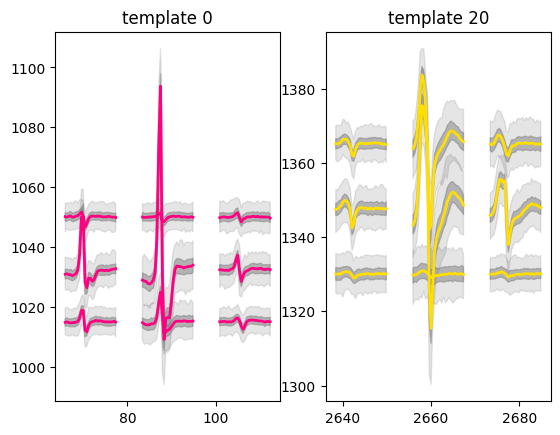

In [43]:
si.plot_unit_templates(analyzer, unit_ids=[0, 20], scale=5)

In [ ]:
"""
# If you used Bombcell and want to use its labels for the training of the model, load the with the following code:
df = pd.read_csv(path_to_sorting / 'cluster_KSLabel.tsv', sep='\t')
manual_labels = ['good' if unit_type == 'GOOD' else 'bad' for unit_type in df['bc_unitType']]
"""

In [ ]:
from spikeinterface.extractors.toy_example import generate_ground_truth_recording

# --- Define Output Directory for Labels ---
# IMPORTANT: Change this to your desired output directory, e.g., your sorter_output folder.
# This path should exist or be created before exporting.
# output_dir_for_labels = path_to_sorting # Change if needed

output_dir_for_labels = 'KiloSort_Quality_Control/'


# --- Load Your SpikeInterface Data ---
# Ensure rec_train, sorting_train, and analyzer are defined BEFORE this cell runs.
# If not, toy data will be generated for demonstration purposes.
if 'rec_train' not in locals() or 'sorting_train' not in locals() or 'analyzer' not in locals():
    print("WARNING: rec_train, sorting_train, or analyzer not defined. Generating toy data.")
    
    recording = generate_ground_truth_recording(
        durations=[10], sampling_frequency=30000, num_channels=4, seed=42
    )
    from spikeinterface.sorting_tools import NumpySorting
    spike_times = np.array([1000, 1050, 2000, 2050, 3000, 3050, 4000, 4050])
    spike_clusters = np.array([0, 0, 1, 1, 2, 2, 3, 3])
    sorting = NumpySorting.from_times_labels(spike_times, spike_clusters, sampling_frequency=recording.sampling_frequency)
    
    import tempfile
    temp_waveforms_folder = Path(tempfile.mkdtemp())
    analyzer = si.create_sorting_analyzer(sorting, recording, folder=temp_waveforms_folder, format="binary", sparse=False)
    analyzer.compute("random_spikes")
    analyzer.compute("unit_waveforms")
    analyzer.compute("correlograms")
    print(f"Loaded {len(sorting.get_unit_ids())} units from toy data.")
else:
    recording = rec_train
    sorting = sorting_train
    print(f"Using pre-defined rec_train, sorting_train, and analyzer. Loaded {len(sorting.get_unit_ids())} units.")

# --- Initialize Unit Properties for Labeling ---
unit_ids = sorting.get_unit_ids()
initial_labels = ['unlabeled'] * len(unit_ids)
sorting.set_property('quality_label', initial_labels)

current_unit_labels = {unit_id: 'unlabeled' for unit_id in unit_ids}
for i, unit_id in enumerate(unit_ids):
    current_unit_labels[unit_id] = sorting.get_property('quality_label')[i]

# --- Create Interactive Widgets ---
unit_selector = widgets.Dropdown(
    options=unit_ids,
    value=unit_ids[0],
    description='Select Unit:',
    disabled=False,
)

output_plot = widgets.Output()

button_good = widgets.Button(description="Label as Good", button_style='success')
button_mua = widgets.Button(description="Label as MUA", button_style='warning')
button_noise = widgets.Button(description="Label as Noise", button_style='danger')
button_unlabeled = widgets.Button(description="Unlabel", button_style='info')
button_export = widgets.Button(description="Export Labels to TSV", button_style='primary') # New button

label_status = widgets.Textarea(
    value='Labels will appear here.',
    description='Unit Labels:',
    disabled=True,
    layout=widgets.Layout(width='auto', height='150px')
)

# --- Define Update and Labeling Functions ---
def update_plot(change):
    selected_unit_id = change['new']
    with output_plot:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sw.plot_unit_templates(analyzer, unit_ids=[selected_unit_id], ax=axes[0], same_axis=True, scale=5)
        axes[0].set_title(f"Waveforms for Unit {selected_unit_id} (Label: {current_unit_labels[selected_unit_id]})")

        sw.plot_autocorrelograms(analyzer, unit_ids=[selected_unit_id], ax=axes[1])
        axes[1].set_title(f"Autocorrelogram for Unit {selected_unit_id}")
        
        plt.tight_layout()
        plt.show()

def update_label_status():
    sorted_labels = current_unit_labels.items()
    label_text = "\n".join([f"Unit {uid}: {label}" for uid, label in sorted_labels])
    label_status.value = label_text

def apply_label(b):
    selected_unit_id = unit_selector.value
    label = b.description.split(" ")[2].lower()
    if label == "unlabel":
        label = "unlabeled"

    current_unit_labels[selected_unit_id] = label
    idx = np.where(unit_ids == selected_unit_id)[0][0] 
    new_property_values = list(sorting.get_property('quality_label'))
    new_property_values[idx] = label
    sorting.set_property('quality_label', new_property_values)

    with output_plot:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sw.plot_unit_templates(analyzer, unit_ids=[selected_unit_id], ax=axes[0], same_axis=True, scale=5)
        axes[0].set_title(f"Waveforms for Unit {selected_unit_id} (Label: {current_unit_labels[selected_unit_id]})")

        sw.plot_autocorrelograms(analyzer, unit_ids=[selected_unit_id], ax=axes[1])
        axes[1].set_title(f"Autocorrelogram for Unit {selected_unit_id}")

        plt.tight_layout()
        plt.show()
    update_label_status()
    print(f"Unit {selected_unit_id} labeled as '{label}'")

    # --- Go to next unit automatically ---
    current_unit_index = list(unit_ids).index(selected_unit_id)
    next_unit_index = current_unit_index + 1

    if next_unit_index < len(unit_ids):
        unit_selector.value = unit_ids[next_unit_index]
    else:
        print("All units reviewed!")
        # Optionally, you could reset to the first unit or disable the selector
        # unit_selector.value = unit_ids[0]
        # unit_selector.disabled = True

def export_labels_to_tsv(b):
    """Exports the current unit labels to a TSV file."""
    labels_df = pd.DataFrame({
        'unit_id': list(current_unit_labels.keys()),
        'quality_label': list(current_unit_labels.values())
    })
    output_filepath = Path(output_dir_for_labels) / "manual_unit_labels.tsv"
    labels_df.to_csv(output_filepath, sep='\t', index=False)
    print(f"Labels exported to: {output_filepath}")

# --- Connect Widgets to Functions ---
unit_selector.observe(update_plot, names='value')

button_good.on_click(apply_label)
button_mua.on_click(apply_label)
button_noise.on_click(apply_label)
button_unlabeled.on_click(apply_label)
button_export.on_click(export_labels_to_tsv) # Connect the new button

# Initial plot and label status update
update_plot({'new': unit_selector.value})
update_label_status()

# --- Arrange and Display Widgets ---
label_buttons = widgets.HBox([button_good, button_mua, button_noise, button_unlabeled])
export_button_box = widgets.HBox([button_export])
ui = widgets.VBox([unit_selector, label_buttons, output_plot, label_status, export_button_box])

print("Displaying interactive GUI...")
display(ui)

# Example to access labeled data:
# good_units = [uid for uid, label in current_unit_labels.items() if label == 'good']
# print("\nExample: Good units after labeling:", good_units)

In [46]:
# Interactive GUI to manually label your data
updated_sorting = ul.interactive_unit_labeler(rec_train, sorting_train, analyzer, output_dir_for_labels='KiloSort_Quality_Control/')

Displaying interactive GUI...


In [52]:
model_folder = "models/"
#manual_labels = pd.read_csv(Path(output_dir_for_labels) / "manual_unit_labels.tsv", sep='\t')
manual_labels = pd.read_csv("KiloSort_Quality_Control/manual_unit_labels.tsv", sep='\t')
manual_labels = manual_labels['quality_label'].tolist()
manual_labels = ['good' if unit_type == 'good' else 'bad' for unit_type in manual_labels]
print(manual_labels)

trainer = sc.train_model(
    mode="analyzers",
    labels=[manual_labels],
    analyzers=[analyzer],
    folder=model_folder,
    overwrite=True, # Set to True if you want to overwrite existing models
    metric_names = None, # Specify which metrics to use for training: by default uses those already calculted
    imputation_strategies = ["median"], # Defaults to all
    scaling_techniques = ["standard_scaler"], # Defaults to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier","LogisticRegression","MLPClassifier"]
    search_kwargs = {'scoring': 'balanced_accuracy',
                     'cv': 3} # Parameters used during the model hyperparameter search
)

best_model = trainer.best_pipeline

accuracies = pd.read_csv(Path(model_folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

['bad', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad']


,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),1.0,1.0,1.0,0,"{'n_estimators': 150, 'min_samples_split': 2, ..."


In [54]:
model, model_info = sc.load_model(
    model_folder=model_folder,
    trusted=['numpy.dtype'] # Specify which modules are trusted
)

labels_and_probababilities = si.auto_label_units(
    sorting_analyzer=analyzer,
    model_folder=model_folder,
    trust_model=True
)

""" 
# We can load a pretrained model from HuggingFace instead of training one
model, model_info = sc.load_model(
    sorting_analyzer = analyzer,
    repo_id = "SpikeInterface/toy_tetrode_model",
    trusted = ['numpy.dtype']
)


# The returned labels and probabilities are stored in the sorting analyzer
labels = analyzer.sorting.get_property("classifier_label")
probabilities = analyzer.sorting.get_property("classifier_probability")
"""

print(labels_and_probababilities)

#sw.plot_unit_templates(analyzer, unit_ids=['3','9'])


   prediction  probability
0         bad     0.982074
1        good     0.620492
2         bad     0.556732
3        good     0.786858
6        good     0.808228
7        good     0.571773
8         bad     0.528141
9        good     0.837140
10       good     0.893923
11       good     0.893698
12       good     0.764648
13       good     0.831733
14       good     0.906534
15        bad     0.985329
16        bad     0.980454
17        bad     0.928557
18        bad     0.969423
19        bad     0.971904
20        bad     0.929475
22        bad     0.979259
23        bad     0.965374
24        bad     0.788374
26        bad     0.755690
27        bad     0.819664
28        bad     0.946421
29        bad     0.973437
30        bad     0.934909
31        bad     0.954281
32        bad     0.951788
33        bad     0.822218
34        bad     0.917641
35        bad     0.850465
36        bad     0.886343
37       good     0.521640
38        bad     0.710331
39        bad     0.863259
4

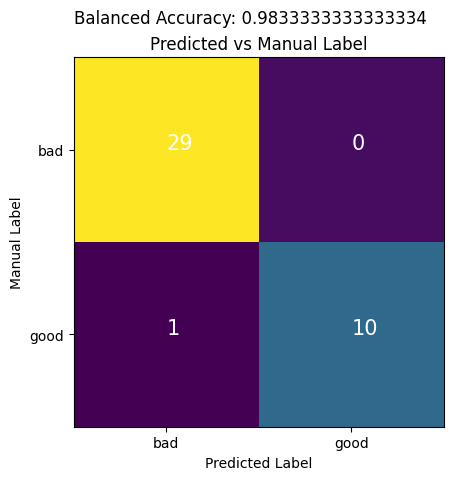

In [55]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

label_conversion = model_info['label_conversion']
predictions = labels_and_probababilities['prediction']

conf_matrix = confusion_matrix(manual_labels, predictions)

# Calculate balanced accuracy for the confusion matrix
balanced_accuracy = balanced_accuracy_score(manual_labels, predictions)

plt.imshow(conf_matrix)
for (index, value) in np.ndenumerate(conf_matrix):
    plt.annotate( str(value), xy=index, color="white", fontsize="15")
plt.xlabel('Predicted Label')
plt.ylabel('Manual Label')
plt.xticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.yticks(ticks = [0, 1], labels = list(label_conversion.values()))
plt.title('Predicted vs Manual Label')
plt.suptitle(f"Balanced Accuracy: {balanced_accuracy}")
plt.show()

#### Apply Model

In [ ]:
const = 1

"""
model, model_info = sc.load_model(
    repo_id = "SpikeInterface/UnitRefine_noise_neural_classifier",
    trusted = ['numpy.dtype']
)
"""


#for stream_id in tqdm(stream_ids):
for i in range(10):
    """
    h5 = h5py.File(path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(path, stream_id=stream_id, rec_name=rec_name)

    path_to_sorting = Path(save_root) / stream_id / 'sorter_output'
    sorting = si.read_kilosort(folder_path=path_to_sorting)
    """

    rec, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=const, num_units=5)
    _, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=const+1, num_units=5)
    const += 2

    sorting = si.aggregate_units([sorting_1, sorting_2])

    analyzer = si.create_sorting_analyzer(sorting=sorting, recording=rec)
    analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components', 'quality_metrics', 'template_metrics'])

    all_metric_names = list(analyzer.get_extension('quality_metrics').get_data().keys()) + list(analyzer.get_extension('template_metrics').get_data().keys())
    print(set(model.feature_names_in_).issubset(set(all_metric_names)))

    labels_and_probababilities = si.auto_label_units(
        sorting_analyzer=analyzer,
        model_folder=model_folder,
        #repo_id="SpikeInterface/UnitRefine_noise_neural_classifier",
        trust_model=True
    )

    print(labels_and_probababilities)

    #labels_and_probababilities = pd.DataFrame(labels_and_probababilities)
    #labels_and_probababilities.to_csv(path_to_sorting / 'labels_and_probabilities.csv')